In [1]:
%pip install tropycal mpl-tools setuptools_scm netcdf4 seaborn shapely cartopy basemap

     ---------------------------------------- 0.0/507.1 kB ? eta -:--:--
     -- ------------------------------------ 30.7/507.1 kB 1.4 MB/s eta 0:00:01
     ----- ------------------------------- 81.9/507.1 kB 770.8 kB/s eta 0:00:01
     -------- --------------------------- 122.9/507.1 kB 901.1 kB/s eta 0:00:01
     ------------------ ------------------- 245.8/507.1 kB 1.4 MB/s eta 0:00:01
     ------------------------------ ------- 409.6/507.1 kB 1.8 MB/s eta 0:00:01
     -------------------------------------- 507.1/507.1 kB 2.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/30.5 MB ? eta -:--:--
     ---------------------------------------- 0.1/30.5 MB 7.5 MB/s eta 0:00:05
     ---------------------------------------- 0.2/30.5 MB 2.3 MB/s eta 0:00:14
      --------------------------------------- 0.6/30.5 MB 5.1 MB/s eta 0:00:06
     - -------------------------------------- 0.8/30.5 MB 4.3 MB/s eta 0:00:07
     - -------------------------------------- 1.0/30.5 MB 4


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import tropycal.tracks as tracks
import pandas as pd
import numpy as np
import datetime as dt
from mpl_toolkits.basemap import Basemap

d:\Programs\Python\lib\site-packages\setuptools_scm\_integration\setuptools.py:31: RuntimeWarning: 
ERROR: setuptools==58.1.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(


# New Section

In [3]:
file= Dataset('./IBTrACS.WP.v04r01.nc', 'r')
print(file.variables.keys())
time = file.variables['time'][:]
d_times=nc.num2date(file.variables['time'][:],file.variables['time'].units
                    ,only_use_cftime_datetimes=False,only_use_python_datetimes=True)
number=file.variables['number'][:]
numobs=file.variables['numobs'][:]
lat=file.variables['lat'][:]
lon=file.variables['lon'][:]
file.close()

dict_keys(['numobs', 'sid', 'season', 'number', 'basin', 'subbasin', 'name', 'source_usa', 'source_jma', 'source_cma', 'source_hko', 'source_kma', 'source_new', 'source_reu', 'source_bom', 'source_nad', 'source_wel', 'source_td5', 'source_td6', 'source_ds8', 'source_neu', 'source_mlc', 'time', 'iso_time', 'nature', 'lat', 'lon', 'wmo_wind', 'wmo_pres', 'wmo_agency', 'track_type', 'main_track_sid', 'dist2land', 'landfall', 'iflag', 'usa_agency', 'usa_atcf_id', 'usa_lat', 'usa_lon', 'usa_record', 'usa_status', 'usa_wind', 'usa_pres', 'usa_sshs', 'usa_r34', 'usa_r50', 'usa_r64', 'usa_poci', 'usa_roci', 'usa_rmw', 'usa_eye', 'tokyo_lat', 'tokyo_lon', 'tokyo_grade', 'tokyo_wind', 'tokyo_pres', 'tokyo_r50_dir', 'tokyo_r50_long', 'tokyo_r50_short', 'tokyo_r30_dir', 'tokyo_r30_long', 'tokyo_r30_short', 'tokyo_land', 'cma_lat', 'cma_lon', 'cma_cat', 'cma_wind', 'cma_pres', 'hko_lat', 'hko_lon', 'hko_cat', 'hko_wind', 'hko_pres', 'kma_lat', 'kma_lon', 'kma_cat', 'kma_wind', 'kma_pres', 'kma_r50_

Western Pacific (WP) locations: 5–60°N 100°–180°E

In [4]:
years=[]
for i in range (len(d_times)):
    years.append(d_times[i][0].year)

In [5]:
df = pd.DataFrame(years, columns=['years'])
df['count'] = df.groupby('years')['years'].transform('size')
df = df.drop_duplicates().reset_index(drop=True)
df

,years,count
0,1884,14
1,1885,9
2,1886,15
3,1887,21
4,1888,13
...,...,...
136,2020,28
137,2021,29
138,2022,31
139,2023,20


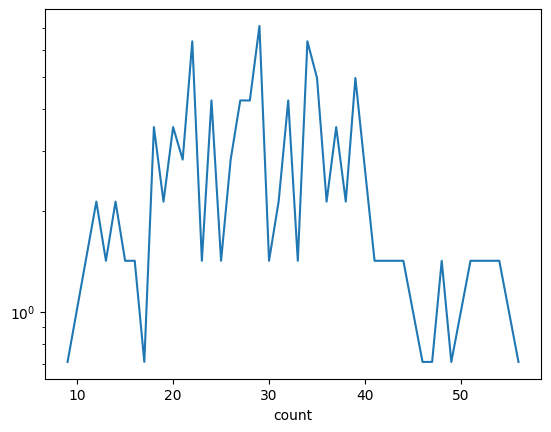

In [6]:
(((df['count'].value_counts())*100/len(df)).sort_index()).plot()
plt.yscale('log')

In [ ]:
df['count'].value_counts().sort_index()


count
9      1
12     3
13     2
14     3
15     2
16     2
17     1
18     5
19     3
20     5
21     4
22     9
23     2
24     6
25     2
26     4
27     6
28     6
29    10
30     2
31     3
32     6
33     2
34     9
35     7
36     3
37     5
38     3
39     7
41     2
42     2
43     2
44     2
46     1
47     1
48     2
49     1
51     2
54     2
56     1
Name: count, dtype: int64

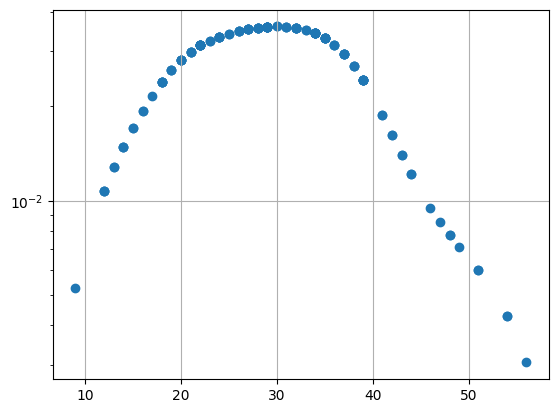

In [11]:
kde=gaussian_kde(df['count'])
pdf=kde(df['count'])
plt.scatter(df['count'],pdf)
plt.yscale('log')
plt.grid()
plt.show()

In [9]:
file_model=Dataset('./Dataset/d4PDF_tropical_cyclone/MRI_HFB_4K_CC_m101.nc','r')
print(file_model.variables.keys())
time_model=file_model.variables['track_time'][:]
masked_time=np.ma.masked_invalid(time_model)
time_model=nc.num2date(masked_time,file_model.variables['track_time'].units
                    ,only_use_cftime_datetimes=False,only_use_python_datetimes=True)
lat_model=file_model.variables['track_lat'][:]
lon_model=file_model.variables['track_lon'][:]


FileNotFoundError: [Errno 2] No such file or directory: './Dataset/d4PDF_tropical_cyclone/MRI_HFB_4K_CC_m101.nc'